# Implementing and Training ConvCNPs for Hydrology 

The ConvCNP ([Convolutional Conditional Neural Process](https://openreview.net/forum?id=Skey4eBYPS)) is a recently introduced member of the neural process family that leverages translation equivariance as an inductive bias when performing inference on sets. This repository contains the  necessary classes and scripts to reproduce the 1d experiments using the CAMELS hydrological dataset.

In [1]:
import os
#%cd convcnp
os.getcwd()

'C:\\Google Drive (mg963)\\MResProject\\convcnp\\convcnp'

In [2]:
#os.chdir('c:\\Users\\marcg\\Google Drive\\MResProject')
#!pip install -r requirements.txt

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import pandas as pd
import pdb
import torch
import torch.nn as nn
import pickle

from sklearn import preprocessing
from scipy.special import inv_boxcox
from scipy.stats import boxcox
#import stheno.torch as stheno

#import convcnp.data
import convcnp.data_hydro_2
import convcnp.data_hydro_2_extended
import convcnp.data_365
import NSE
from metrics import *
#import convcnp.task_preprocessing as tp

from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, gamma_logpdf, init_sequential_weights, to_multiple, to_numpy, gamma_stats
from convcnp.plot_utils import *
from convcnp.transformations import *
from convcnp.architectures import SimpleConv, UNet, SeparableConv1d, Conv1d, DepthSepConv1d
from convcnp.convcnp_architectures import DeepSet, ConvDeepSet, FinalLayer, ConvCNP

from numpy import loadtxt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
%%time
filepath = r'../../data/camels_processed/daymet_merged/daymet_data_seed05.csv'
df_raw = pd.read_csv(filepath)

Wall time: 17.9 s


In [5]:
basins_file = r'C:\Google Drive (mg963)\ealstm_regional_modelling\ealstm_regional_modeling\data\basin_list.txt'
selected_basins = loadtxt(basins_file, comments="#", delimiter=",", unpack=False, dtype="int")

In [6]:
%%time
df_raw = df_raw[df_raw['basin'].isin(selected_basins)]
len(df_raw)

Wall time: 1.69 s


6521041

In [7]:
df_raw.drop(['MOD_RUN'],axis=1,inplace=True)
print(len(df_raw))
df_raw.drop_duplicates(inplace=True)
print(len(df_raw))

6521041
6520841


In [8]:
df_raw = df_raw[df_raw['OBS_RUN']>=0]
#df_raw[df_raw['OBS_RUN']<0] = 0
print(len(df_raw))
df = df_raw.copy()

6518953


In [9]:
transformation = 'boxcox'
trans_fields = ['OBS_RUN','prcp(mm/day)']
gamma_dist = True

if transformation == 'log':
    for trans_field in trans_fields:
        df[trans_field] = log_transform(df_raw[trans_field], 1)
if transformation == 'boxcox':
    for trans_field in trans_fields:
        df[trans_field], lambda_val = boxcox_transform(df_raw[trans_field], 1e-6)
        
        for ch in ['(',')','/']:
            trans_field = trans_field.replace(ch,"_")
        
        exec("lambda_" + trans_field + " = " + str(lambda_val))
        print("lambda_" + trans_field + " = ", lambda_val)


lambda_OBS_RUN =  0.1866535246938145
lambda_prcp_mm_day_ =  -0.1268594255050134


In [10]:
df.describe()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),basin,YR,MNTH,...,PRCP,RAIM,TAIR,PET,ET,OBS_RUN,seed,DOY,doy_sin,doy_cos
count,6.518953e+06,6.518953e+06,6.518953e+06,6518953.0,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,...,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,6.518953e+06,6518953.0,6.518953e+06,6.518953e+06,6.518953e+06
mean,4.313971e+04,-2.407760e+01,3.387796e+02,0.0,1.653996e+01,4.271522e+00,9.674314e+02,6.003416e+06,1.997579e+03,6.555760e+00,...,3.383557e+00,3.498308e+00,1.040574e+01,2.753581e+00,1.938441e+00,-6.343326e-01,5.0,1.841201e+02,3.059517e-05,2.193808e-05
std,7.122397e+03,1.855849e+01,1.319555e+02,0.0,1.107275e+01,1.013475e+01,6.557006e+02,4.022061e+06,9.785819e+00,3.457828e+00,...,7.946632e+00,8.329368e+00,1.038671e+01,1.965253e+00,1.514040e+00,1.745500e+00,0.0,1.057217e+02,1.214335e-02,1.213464e-02
min,2.902981e+04,-3.759866e+01,1.305000e+01,0.0,-3.807000e+01,-4.884000e+01,0.000000e+00,1.022500e+06,1.980000e+03,1.000000e+00,...,0.000000e+00,0.000000e+00,-4.345500e+01,0.000000e+00,0.000000e+00,-4.951037e+00,5.0,1.000000e+00,-1.716701e-02,-1.716717e-02
25%,3.663360e+04,-3.759866e+01,2.400700e+02,0.0,8.180000e+00,-2.450000e+00,4.772700e+02,2.221525e+06,1.989000e+03,4.000000e+00,...,0.000000e+00,0.000000e+00,3.035000e+00,9.454000e-01,6.599000e-01,-1.651167e+00,5.0,9.200000e+01,-1.205836e-02,-1.211232e-02
50%,4.319999e+04,-3.759866e+01,3.400500e+02,0.0,1.759000e+01,4.140000e+00,7.610200e+02,5.488200e+06,1.998000e+03,7.000000e+00,...,0.000000e+00,0.000000e+00,1.082000e+01,2.423700e+00,1.547700e+00,-6.299843e-01,5.0,1.840000e+02,-5.174933e-07,7.597672e-05
75%,4.976634e+04,1.037005e+00,4.365200e+02,0.0,2.549000e+01,1.191000e+01,1.337090e+03,8.380500e+06,2.006000e+03,1.000000e+01,...,3.040000e+00,2.750700e+00,1.853000e+01,4.354000e+00,2.972800e+00,3.997458e-01,5.0,2.760000e+02,1.216567e-02,1.211195e-02
max,5.737020e+04,3.857704e+00,8.000000e+02,0.0,4.516000e+01,2.850000e+01,3.659250e+03,1.440000e+07,2.014000e+03,1.200000e+01,...,2.000000e+02,2.000000e+02,3.595000e+01,1.070700e+01,1.065350e+01,1.146813e+01,5.0,3.660000e+02,1.716700e-02,1.716651e-02


In [15]:
dist = 'gaussian'
if dist=='gamma':
    Q_shift = df['OBS_RUN'].min()
    df['OBS_RUN'] = df['OBS_RUN'] + Q_shift + 1

In [16]:
OBS_RUN_min = df['OBS_RUN'].min()
OBS_RUN_max = df['OBS_RUN'].max()

#OBS_RUN_min = df_raw['OBS_RUN'].min()
#OBS_RUN_max = df_raw['OBS_RUN'].max()

df_raw['OBS_RUN_log'] = df_raw['OBS_RUN'].transform(lambda x: np.log(x + 1))
df_raw['OBS_RUN_log_n'] = df_raw['OBS_RUN_log'].transform(lambda x: (x - x.mean())/x.std())

mu_raw = df_raw['OBS_RUN'].mean()
sigma_raw = df_raw['OBS_RUN'].std()
mu_log = df_raw['OBS_RUN_log'].mean()
sigma_log = df_raw['OBS_RUN_log'].std()
mu_log_n = df_raw['OBS_RUN_log_n'].mean()
sigma_log_n = df_raw['OBS_RUN_log_n'].std()

In [17]:
fields = [#'OBS_RUN',
        'prcp(mm/day)', 
          'srad(W/m2)','swe(mm)', 'tmax(C)','tmin(C)', 'vp(Pa)',
         ]
for field in fields:
    #varname_mu = f'{field.split("(")[0]}_mu'
    #varname_sigma = f'{field.split("(")[0]}_sigma'
    #df[field], vars()[varname_mu], vars()[varname_sigma] = normalise(df[field])
    df[field] = normalise(df[field])

In [162]:
random_train_test_split = True

if random_train_test_split == True:
    fraction_test_locations = 0.1

    #hru02 = ['hru_02']
    hru02 = df['hru02'].unique().tolist()

    #hru04 = 'hru_0101'
    #hru08 = 'hru_01013500'

    hru08 = df['hru08'][df['hru02'].isin(hru02)].unique()
    #hru08 = df['hru08'] == 'hru_01013500'

    rand_locations = np.arange(len(hru08))
    np.random.shuffle(rand_locations)
    num_test_locations = int(len(hru08)*fraction_test_locations)
    rand_locations_test = rand_locations[0:num_test_locations]
    rand_locations_train = rand_locations[num_test_locations:]
    hru08_test = hru08[rand_locations_test]
    hru08_train = hru08[rand_locations_train]

    print(f'Train test split random: {len(rand_locations_train)} train and {len(rand_locations_test)} test locations')
    
else:
    path = 'train_test_splits/hru01_train_001.pkl'
    a_file = open(path, "rb")
    hru08_train = pickle.load(a_file)
    a_file.close()
    
    path = 'train_test_splits/hru01_test_001.pkl'
    a_file = open(path, "rb")
    hru08_test = pickle.load(a_file)
    a_file.close()
    
    print('Train test split not random')

Train test split random: 478 train and 53 test locations


In [163]:
df['OBS_RUN_mean'] = df.groupby('hru08')['OBS_RUN'].transform(lambda x: x.mean())
#df['OBS_RUN_log_n_mean'] = df.groupby('hru08')['OBS_RUN_log_n'].transform(lambda x: x.mean())

s_date_tr = '1980-10-01'
e_date_tr = '1995-09-30'

s_date_te = '1995-10-01'
e_date_te = '2010-09-30'

context_channels = ['OBS_RUN',
                    'doy_cos','doy_sin',
                    'prcp(mm/day)', 
                    'srad(W/m2)',  
                    'tmax(C)',
                    'tmin(C)', 
                    'vp(Pa)'
                   ]

target_channels = context_channels
target_val_channel = ['OBS_RUN_mean']

context_mask = [0,1,1,1,1,1,1,1]
target_mask = [0,1,1,1,1,1,1,1]

attributes = [#'gauge_id', 
               'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
               'aridity', 'high_prec_freq', 'high_prec_dur', 
                #'high_prec_timing',
               'low_prec_freq', 'low_prec_dur', 
                #'low_prec_timing', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
               'carbonate_rocks_frac', #'geol_porostiy', 
                'geol_permeability', 
                #'q_mean','runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
               #'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
               #'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
               'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity','soil_conductivity', 
                'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 
                #'water_frac', 'organic_frac', 'other_frac', 
                #'gauge_lat','gauge_lon', 
                'elev_mean', 'slope_mean', 
                #'area_gages2',
                'area_geospa_fabric', 
                'frac_forest', 'lai_max', 'lai_diff', 'gvf_max','gvf_diff', 
                #'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50','root_depth_99', 'hru08'
                ]

df_train = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['hru08'].isin(hru08_train))].copy()
df_test_both = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['hru08'].isin(hru08_test))].copy()
df_test_catchment = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['hru08'].isin(hru08_test))].copy()
df_test_temporal = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['hru08'].isin(hru08_train))].copy()

list_to_drop = ['MNTH','DY','hru02','hru04','RAIM','TAIR','PET','ET','SWE','swe(mm)','PRCP','seed','id_lag','HR','dayl(s)']

df_train.drop(list_to_drop,axis=1,inplace=True)
df_test_both.drop(list_to_drop,axis=1,inplace=True)
df_test_catchment.drop(list_to_drop,axis=1,inplace=True)
df_test_temporal.drop(list_to_drop,axis=1,inplace=True)

df_train.reset_index(drop=True,inplace=True)
df_test_temporal.reset_index(drop=True,inplace=True)
df_test_catchment.reset_index(drop=True,inplace=True)
df_test_both.reset_index(drop=True,inplace=True)

In [164]:
#%%capture
"""import pickle
step = 5
data = hru08_test
name = "hru01_test"
path = ("train_test_splits/%s_%s.pkl" % (name, str(step).zfill(3)))
print(path)
a_file = open(path, "wb")
pickle.dump(data, a_file)
a_file.close()"""

'import pickle\nstep = 5\ndata = hru08_test\nname = "hru01_test"\npath = ("train_test_splits/%s_%s.pkl" % (name, str(step).zfill(3)))\nprint(path)\na_file = open(path, "wb")\npickle.dump(data, a_file)\na_file.close()'

In [165]:
observed_at_target_flag = True
feature_embedding_flag = True
feature_embedding_key_flag = True
extrapolate_flag = False

dynamic_feature_embedding_dims = 5
static_feature_embedding_dims = 5

timeslice = 365

min_train_points = 100
max_train_points = 100
min_test_points = 250
max_test_points = 250

In [166]:
%%capture
"""#Calculate mean and standard deviation for raw OBS_RUN variable  

raw_path = r'..\..\data\camels_processed\daymet_model_output\daymet_model_output_seed05.csv'
df_raw = pd.read_csv(raw_path)

df_raw['OBS_RUN_log'] = df_raw['OBS_RUN'].transform(lambda x: np.log(x + 1))
df_raw['OBS_RUN_log_n'] = df_raw['OBS_RUN_log'].transform(lambda x: (x - x.mean())/x.std())

mu_raw = df_raw['OBS_RUN'].mean()
sigma_raw = df_raw['OBS_RUN'].std()
mu_log = df_raw['OBS_RUN_log'].mean()
sigma_log = df_raw['OBS_RUN_log'].std()
mu_log_n = df_raw['OBS_RUN_log_n'].mean()
sigma_log_n = df_raw['OBS_RUN_log_n'].std()

#del df_raw

#mu_raw, sigma_raw, mu_log, sigma_log, mu_log_n, sigma_log_n"""

## Data Generation

As other members of the NP family, ConvCNP learns from a large collection of related tasks, where each training task contains a _context set_ and a _target set_. The context set is used to infer the predictive function, which is evaluated on the target set. In this experiment we will use a Gaussian process to sample a function, from which we will sub-sample (distinct) context and target sets. 

In this repository, we use [Stheno](https://github.com/wesselb/stheno) to handle GPs. Our generator class (found in [convnp.data](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/data.py)) handles the data generation process for us! All we need to do is create a Stheno kernel and pass it to the generator (other arguments like batch size and number of tasks per "epoch" can also be controlled).

Let us define such a generator, and plot a few tasks to see what these look like.

In [167]:
path = '../../data/camels_processed/attibutes.csv'
df_att = pd.read_csv(path)
numeric_attributes = df_att.select_dtypes('float64').columns.tolist()
from sklearn import preprocessing
#df_att_n = pd.DataFrame()
for att in numeric_attributes:
    df_att[att] = standardise(df_att[att])

#df_att_n['hru08'] = df_att['hru08']
df_att.describe()

,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,...,area_gages2,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,root_depth_50,root_depth_99
count,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,...,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.470000e+02,6.470000e+02
mean,6.265831e+06,2.117862e-17,-6.565373e-16,4.235724e-17,-1.270717e-16,2.117862e-16,-4.712243e-16,-4.659297e-16,9.318593e-16,-4.235724e-17,...,4.235724e-17,8.471448e-17,4.235724e-17,-2.965007e-16,-4.235724e-17,-1.694290e-16,-8.471448e-17,2.700274e-16,8.785691e-17,-5.930341e-16
std,3.976868e+06,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,...,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000774e+00,1.000774e+00
min,1.013500e+06,-1.854105e+00,-1.601758e+00,-2.645322e+00,-8.743119e-01,-1.359749e+00,-2.869106e+00,-1.437080e+00,-2.415197e+00,-9.898464e-01,...,-4.636894e-01,-4.705536e-01,-1.717546e+00,-1.875473e+00,-1.721300e+00,-3.197765e+00,-1.978732e+00,-2.695562e+00,-1.903183e+00,-1.091306e+00
25%,2.370650e+06,-6.276393e-01,-8.153490e-01,-4.216872e-01,-7.013172e-01,-5.867442e-01,-5.352462e-01,-7.374283e-01,-6.254721e-01,-5.357778e-01,...,-3.941585e-01,-3.980518e-01,-9.735011e-01,-9.227738e-01,-9.391841e-01,-6.747449e-01,-9.055895e-01,-8.643935e-01,-4.351155e-01,-1.019088e+00
50%,6.278300e+06,-2.003378e-02,-1.788967e-01,2.318713e-01,-3.922390e-01,-3.274291e-01,2.353679e-01,-3.568680e-01,3.427501e-02,-3.140894e-01,...,-2.722074e-01,-2.735477e-01,4.677257e-01,1.022880e-01,-8.411564e-02,3.461728e-01,-4.560470e-02,2.625029e-01,3.836398e-02,-9.818962e-02
75%,9.382765e+06,3.730640e-01,6.467418e-01,5.033172e-01,2.237837e-01,3.428102e-01,7.252583e-01,4.738788e-01,6.918847e-01,2.339906e-01,...,9.860384e-04,-2.096901e-03,8.939303e-01,9.745365e-01,9.820190e-01,8.490465e-01,9.427633e-01,1.015977e+00,3.619552e-01,5.638879e-01
max,1.440000e+07,4.029519e+00,3.528104e+00,1.827764e+00,3.587368e+00,6.750351e+00,2.591245e+00,3.878269e+00,2.680388e+00,9.558591e+00,...,1.469906e+01,1.463773e+01,9.680529e-01,1.557702e+00,1.787850e+00,1.151071e+00,2.219193e+00,1.033847e+00,2.303502e+00,4.205314e+00


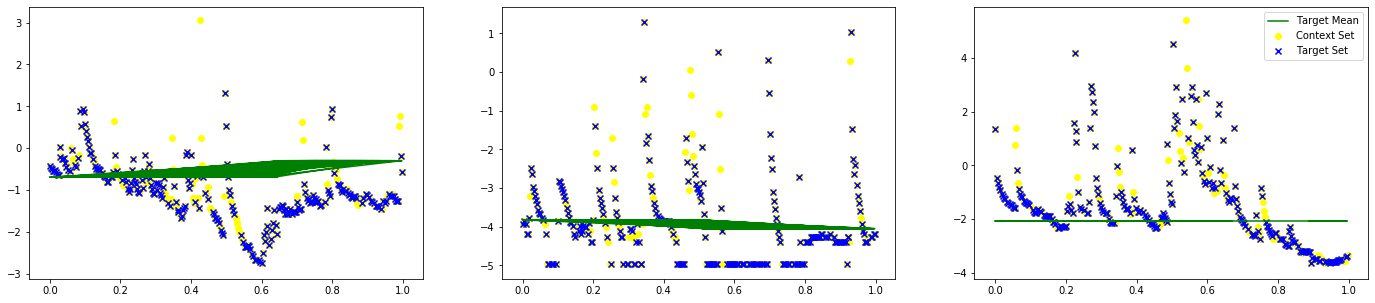

In [169]:
gen = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_train,
                                            df_att = df_att,
                                            batch_size = 16*4,
                                            num_tasks = 256,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0,
                                            concat_static_features = False,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points)
        

task = gen.generate_task()
fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_task(task, i, legend=i==2)
plt.show()

In [170]:
%%capture

# Define parameters
static_embedding_location = "after_encoder"
rho_in_channels = 8 if static_embedding_location != "after_encoder" else 8 + static_feature_embedding_dims
static_embedding_in_channels = len(attributes)

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(context_channels),
                rho=DepthSepConv1d(in_channels=rho_in_channels),
                points_per_unit=64*8,
                static_embedding_in_channels=static_embedding_in_channels,
                static_feature_missing_data=False,
                )

# Assign model to device
model.to(device)

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [171]:
importlib.reload(convcnp.transformations)
from convcnp.transformations import *

In [172]:
def rev_transform(x,a=0,b=0):
    return rev_boxcox_transform(x,ld=lambda_OBS_RUN)

def rev_transform_tensor(x):
    return rev_boxcox_transform_tensor(x,ld=lambda_OBS_RUN)

In [173]:
import scipy.stats

def train(data, model, opt, dist='gaussian'):
    """Perform a training epoch."""
    ravg = RunningAverage()
    ravg_nse = RunningAverage() 
    model.train()
    for step, task in enumerate(data):
        y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)        
        if dist == 'gaussian':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gamma':
            y_mean, y_std = gamma_stats(y_loc, y_scale)
            obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        
        obj.backward()
        opt.step()
        opt.zero_grad()
              
        obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))                         
        ravg.update(obj.item() / data.batch_size, data.batch_size)
        ravg_nse.update(obj_nse.item(), data.batch_size)
        
        if step % 10 == 0:
            print("step %s -- avg training loss is %.3f" % (step, ravg.avg))    
    
    return ravg.avg, ravg_nse.avg

# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)


def plot_model_task(model, task, timeslice, idx, legend, dist='gaussian', feature_embedding_flag=True):
    num_functions = task['x_context'].shape[0]
    x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)
    
    # Make predictions with the model.
    model.eval()
    with torch.no_grad():
        y_loc, y_scale = model(task['x_context'], task['y_context'], x_test.repeat(num_functions, 1, 1), task['y_att'], task['feature'],task['m'],embedding=feature_embedding_flag)
        #y_loc_NSE, y_scale_NSE = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)

    # Plot the task and the model predictions.
    x_context, y_context = to_numpy(task['x_context'][idx]), to_numpy(task['y_context'][idx][:,0])
    x_target, y_target = to_numpy(task['x_target'][idx]), to_numpy(task['y_target'][idx][:,0])
    #y_mean_NSE, y_std_NSE = to_numpy(y_mean_NSE[idx][:,0]), to_numpy(y_std_NSE[idx][:,0])
    y_target_val = to_numpy(task['y_target_val'][idx][:,0])
    
    if dist == 'gaussian':
        y_mean, y_std = y_loc, y_scale
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        p05, p95 = y_mean + 2 * y_std, y_mean - 2 * y_std
        #y_mean_NSE, y_std_NSE = y_loc_NSE, y_scale_NSE
    elif dist == 'gamma':
        y_mean, y_std = gamma_stats(y_loc, y_scale)
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        y_loc, y_scale = to_numpy(y_loc[idx][:,0]), to_numpy(y_scale[idx][:,0])        
        p05 = scipy.stats.gamma.ppf(0.05, y_loc, 0, 1/y_scale)
        p95 = scipy.stats.gamma.ppf(0.95, y_loc, 0, 1/y_scale)
        #y_mean_NSE, y_std_NSE = gamma_stats(y_loc_NSE, y_scale_NSE)

    #nse = NSE.nse(rev_transform(y_target), rev_transform(y_target_val), rev_transform(y_mean_NSE))
    #log_nse = NSE.nse(y_mean_NSE, y_target_val, y_target)
    
    x_context = x_context*timeslice
    x_target = x_target*timeslice
    x_test = to_numpy(x_test[0,:,0])*timeslice
    
    plt.scatter(x_context, rev_transform(y_context), label='Context Set', color='black')
    plt.scatter(x_target, rev_transform(y_target), label='Target Set', color='red')
    #plt.scatter(x_target, rev_transform(y_mean_NSE), label='Target Predictions', color='orange')
    plt.plot(x_target, rev_transform(y_target_val), label='Target Mean', color='green')

    # Plot model predictions.
    plt.plot(x_test, rev_transform(y_mean), label='Model Output', color='blue')
    plt.fill_between(x_test,
                     rev_transform(p95),
                     rev_transform(p05),
                     color='tab:blue', alpha=0.2)
        
    #plt.title("NSE(1): %.3f " % nse)
    #plt.xlabel("Q")
    #plt.ylabel("y-label")
        
    if legend:
        plt.legend()


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [174]:
from collections import OrderedDict, namedtuple
from convcnp.run_manager import RunBuilder, RunManager

In [175]:
networks = {
    'model_1': model
}

trainsets = {
    'trainset_1': df_train
}

params = OrderedDict(
    LEARNING_RATE = [1e-3]
    , NUM_EPOCHS = [20]
    #, batch_size = [1000]
    #, device = ['cuda']
    #, trainset = ['normal']
    #, network = list(models.keys())
)

step 0 -- avg training loss is 9.690
step 10 -- avg training loss is 7.957
step 20 -- avg training loss is 7.835
step 30 -- avg training loss is 7.790
step 40 -- avg training loss is 7.738
step 50 -- avg training loss is 7.716
step 60 -- avg training loss is 7.704
step 70 -- avg training loss is 7.675
step 80 -- avg training loss is 7.646
step 90 -- avg training loss is 7.641
step 100 -- avg training loss is 7.610
step 110 -- avg training loss is 7.555
step 120 -- avg training loss is 7.510
step 130 -- avg training loss is 7.457
step 140 -- avg training loss is 7.417
step 150 -- avg training loss is 7.376
step 160 -- avg training loss is 7.339
step 170 -- avg training loss is 7.318
step 180 -- avg training loss is 7.298
step 190 -- avg training loss is 7.276
step 200 -- avg training loss is 7.256
step 210 -- avg training loss is 7.232
step 220 -- avg training loss is 7.211
step 230 -- avg training loss is 7.190
step 240 -- avg training loss is 7.171
step 250 -- avg training loss is 7.1

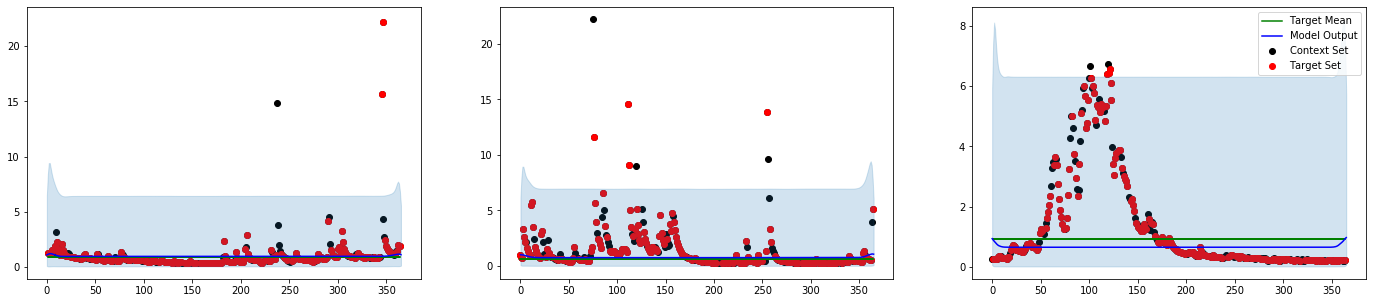

step 0 -- avg training loss is 6.965
step 10 -- avg training loss is 6.645
step 20 -- avg training loss is 6.679
step 30 -- avg training loss is 6.665
step 40 -- avg training loss is 6.675
step 50 -- avg training loss is 6.690
step 60 -- avg training loss is 6.701
step 70 -- avg training loss is 6.689
step 80 -- avg training loss is 6.687
step 90 -- avg training loss is 6.671
step 100 -- avg training loss is 6.669
step 110 -- avg training loss is 6.675
step 120 -- avg training loss is 6.675
step 130 -- avg training loss is 6.670
step 140 -- avg training loss is 6.665
step 150 -- avg training loss is 6.668
step 160 -- avg training loss is 6.669
step 170 -- avg training loss is 6.671
step 180 -- avg training loss is 6.668
step 190 -- avg training loss is 6.664
step 200 -- avg training loss is 6.662
step 210 -- avg training loss is 6.659
step 220 -- avg training loss is 6.657
step 230 -- avg training loss is 6.655
step 240 -- avg training loss is 6.654
step 250 -- avg training loss is 6.6

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Some training hyper-parameters:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
PLOT_FREQ = 100
dist = 'gaussian'

for run in RunBuilder.get_runs(params):
    
    # Initialize optimizer
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    train_obj_list, train_nse_list, epoch_list = [], [], []
    
    # Run the training loop.
    for epoch in range(NUM_EPOCHS):
        # Compute training objective.
        start_time = time.time()
        train_obj, train_nse = train(gen, model, opt, dist=dist)
        elapsed = time.time() - start_time
        
        epoch_list.append(epoch)
        train_obj_list.append(train_obj)
        train_nse_list.append(train_nse)
        
        # Plot model behaviour every now and again.
        if epoch % PLOT_FREQ == 0:
            print('Epoch %s: NLL %.3f -- NSE %.3f -- time: %.3f' % (epoch, train_obj, train_nse, elapsed))
            start = time.time()
            task = gen.generate_task()
            fig = plt.figure(figsize=(24, 5))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)
            plt.show()
            
        else:
            print('Epoch %s: NLL %.3f -- NSE %.3f -- time: %.3f' % (epoch, train_obj, train_nse, elapsed))

In [1]:
#plot training loss
plot_training_loss(train_obj_list, train_nse_list)

NameError: name 'plot_training_loss' is not defined

## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [155]:
"""%%capture
#load model
##model = TheModelClass(*args, **kwargs)
PATH = '../../saved_models/model_022.pt'
model.load_state_dict(torch.load(PATH))
model.eval()"""

"%%capture\n#load model\n##model = TheModelClass(*args, **kwargs)\nPATH = '../../saved_models/model_022.pt'\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()"

In [155]:
df_test = df_test_both

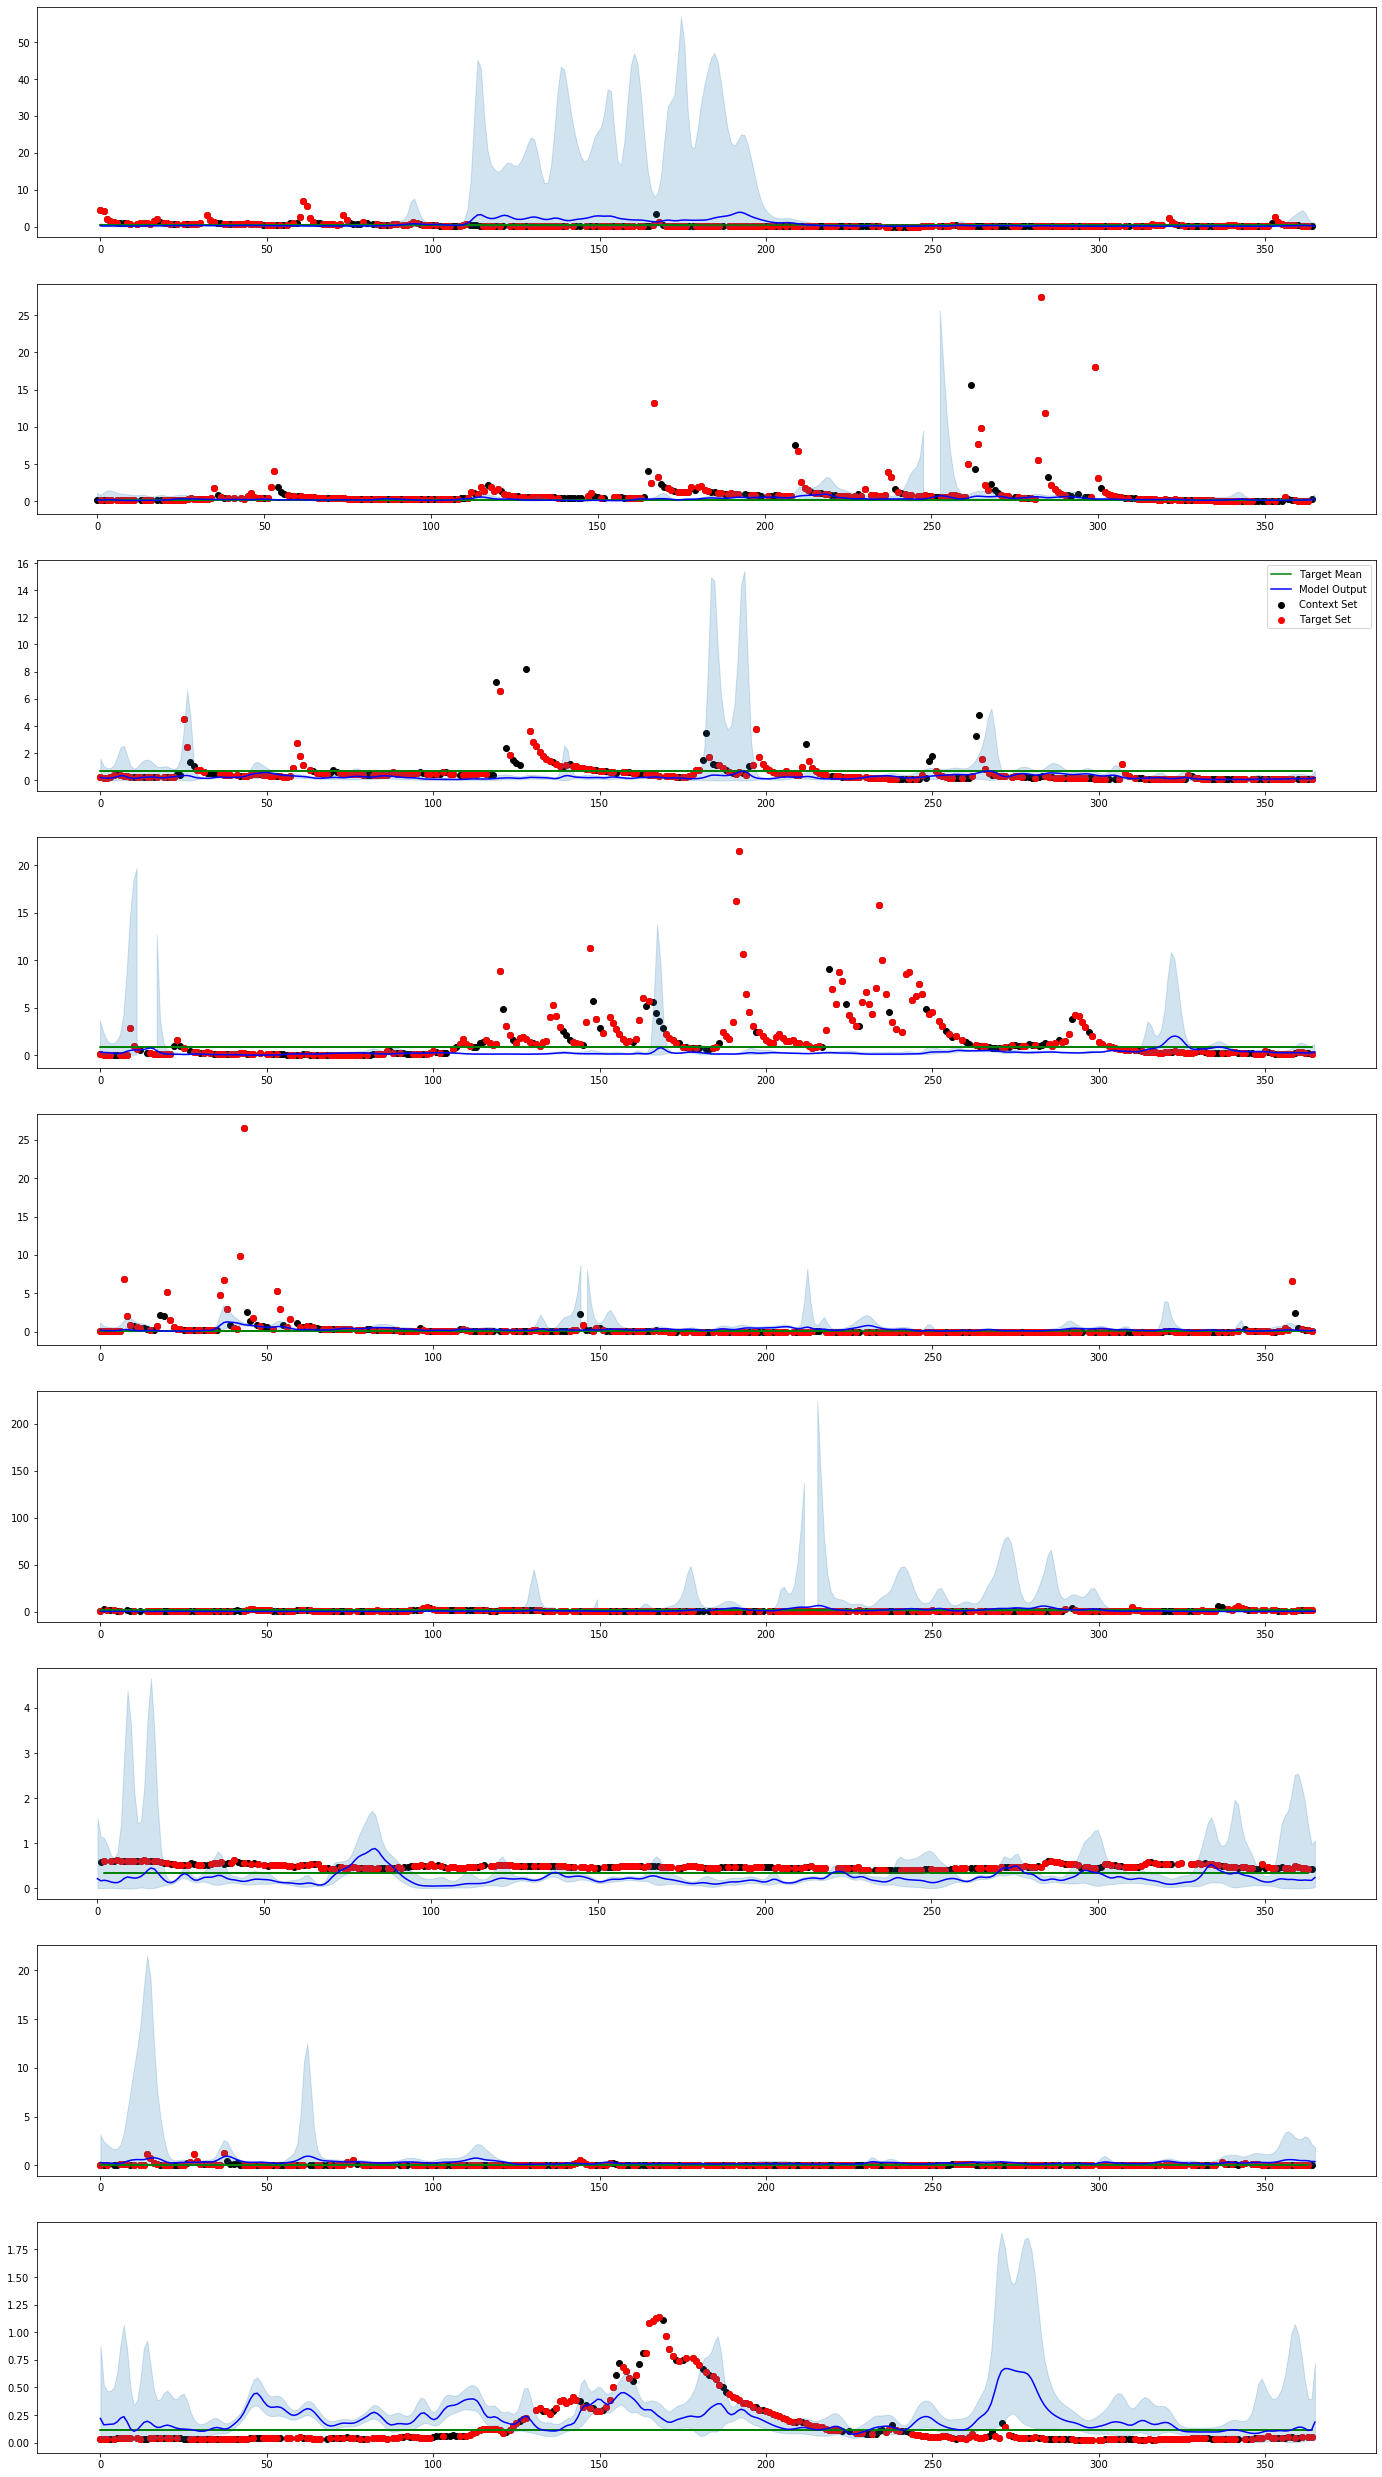

Model averages a log likelihood of -807.945 on unseen tasks -- NSE: nan -- time: 2.497


In [156]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 2
gen_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            concat_static_features=False,
                                            timeslice = timeslice,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points)

# Compute average task log-likelihood.
ravg = RunningAverage()
ravg_nse = RunningAverage()
model.eval()
start = time.time()
with torch.no_grad():
    for step, task in enumerate(gen_test):
        y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)
        
        if dist == 'gaussian':
            obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
            y_mean, y_std = gamma_stats(y_mean, y_std)
        elif diat == 'gamma':
            obj = -gamma_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
            
        obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))        
        ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        ravg_nse.update(obj_nse.item(), gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 45))
    for i in range(9):
        plt.subplot(9, 1, i + 1)
        plot_model_task(model, task, timeslice, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- NSE: %.3f -- time: %.3f' % (-ravg.avg, ravg_nse.avg, elapsed))

In [297]:
"""PATH = r'..\..\saved_models\model_022.pt'
torch.save(model.state_dict(),PATH)"""

## Test NSE performance at 365/1-day ahead task

In [158]:
importlib.reload(convcnp.data_hydro_2_extended)
from convcnp.data_hydro_2_extended import *
importlib.reload(NSE)
from metrics import *
import scipy.stats
df_test = df_test_temporal

1


C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
C:\Google Drive (mg963)\MResProject\convcnp\convcnp\metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astyp

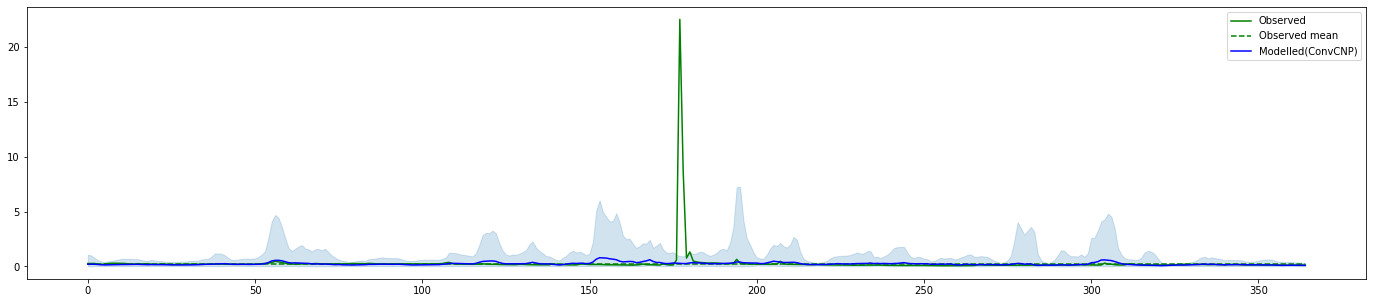

1. Basin hru_06601000 (period: 2000-2001): LL=nan -- NSE=-0.380 -- time=15.919


In [161]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 10
gen_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            concat_static_features = False,
                                            extrapolate = True,
                                            timeslice = 365,
                                            min_train_points=364,
                                            min_test_points=1,
                                            max_train_points=364,
                                            max_test_points=1)

out = np.array([])
out_2 = np.array([])

# Compute average task log-likelihood.
basins = df_test['hru08'].unique().tolist()
#basins = ['hru_01030500','hru_01047000']
print(len(basins))
b=0
for basin in basins[:5]:
    
    b+=1
    
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    rnum = RunningAverage()
    rden = RunningAverage()
    model.eval()
    start = time.time()
    
    pred_mu = np.array([])
    pred_sigma = np.array([])
    pred_loc = np.array([])
    pred_scale = np.array([])
    observations = np.array([])
    DOY = np.array([])
    YR = np.array([])
    HRU = np.array([])
    
    alpha_nse = np.array([])
    beta_nse = np.array([])
    nse_index = np.array([])
    fhv = np.array([])
    flv = np.array([])
    fms = np.array([])
    
    with torch.no_grad():    
        years = df_test['YR'][df_test['hru08']==basin].unique().tolist()
        years = sorted(years)[1:]
        duration = 1
        y = np.random.randint(len(years)-duration)
        for year in years[y:y+duration]:
        #for year in years[:]:
            task = gen_test.generate_test_task(year,basin)
            chunk_size = 100
            chunks = np.arange(0,task['x_context'].shape[0],chunk_size)
            #print(chunks)
            minitask = task.copy()
            for i in range(len(chunks)):
                #print("chunk",i)
                #print(task[k].shape)
                if i+1 == len(chunks):
                    s = chunks[i]
                    e = task[k].shape[0]
                else:
                    s = chunks[i]
                    e = chunks[i+1]

                for k,v in task.items():
                    minitask[k] = task[k][s:e] 
                
                minibatch_size = minitask['x_context'].shape[0]
                y_mean, y_std = model(minitask['x_context'], minitask['y_context'], minitask['x_target'],minitask['y_att'], minitask['feature'],minitask['m'],embedding=feature_embedding_flag)
                #obj = -gaussian_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                obj = -gamma_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                obj_nse = NSE.nse_tensor_batch(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']),rev_transform_tensor(y_mean))
                
                if dist == 'gamma':
                    y_loc = y_mean
                    y_scale = y_std
                    g_mean = torch.distributions.gamma.Gamma(y_mean, y_std).mean
                    g_var = torch.distributions.gamma.Gamma(y_mean, y_std).variance
                    y_mean = g_mean
                    y_std = torch.sqrt(g_var)
                
                num = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(y_mean))
                den = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']))
                
                #print(obj.item(), obj_nse.item(), num.item(), den.item())
                #print(minitask['y_target'].shape)
                
                ravg.update(obj.item() / minibatch_size, minibatch_size)
                ravg_nse.update(obj_nse.item() / minibatch_size, minibatch_size)
                rnum.update(num.item(), minibatch_size)
                rden.update(den.item(), minibatch_size)
                
                observations = np.append(observations, to_numpy(minitask['y_target']))
                pred_mu = np.append(pred_mu, to_numpy(y_mean))
                pred_sigma = np.append(pred_sigma, to_numpy(y_std))
                if dist=='gamma':
                    pred_loc = np.append(pred_loc, to_numpy(y_loc))
                    pred_scale = np.append(pred_scale, to_numpy(y_scale))
                DOY = np.append(DOY, np.arange(s+1,e+1))
                YR = np.append(YR, np.ones(minibatch_size)*year)
                HRU = np.append(HRU, np.array([basin] * minibatch_size))
                
        alpha_nse = np.append(alpha_nse, calc_alpha_nse(observations,pred_mu))
        beta_nse = np.append(beta_nse, calc_beta_nse(observations,pred_mu))
        nse_index = np.append(nse_index, calc_nse(observations,pred_mu))
        fhv = np.append(fhv, calc_fdc_fhv(observations,pred_mu))
        flv = np.append(flv, calc_fdc_flv(observations,pred_mu))
        fms = np.append(fms, calc_fdc_fms(observations,pred_mu))    
            
        out_basin = np.transpose(np.vstack((HRU,YR,DOY,observations,pred_mu,pred_sigma)))
        out_basin_2 = np.transpose(np.vstack((alpha_nse,beta_nse,nse_index,fhv,flv,fms)))
        
        fig = plt.figure(figsize=(24, 5))
        
        x = np.arange(len(observations))
        
        # Plot model predictions.
        plt.plot(x,rev_transform(observations), label='Observed', color='green')
        plt.plot(x,rev_transform(np.ones(len(pred_mu))*pred_mu.mean()), label='Observed mean', linestyle='dashed', color='green')
        plt.plot(x,rev_transform(pred_mu), label='Modelled(ConvCNP)', color='blue')
        
        if dist=='gaussian':
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale)
            p95 = scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale)
            plt.fill_between(x,
                            rev_transform(p05),
                            rev_transform(p95),
                            color='tab:blue', alpha=0.2)
        
        plt.legend()
        plt.show()

        nse_2 = 1 - rnum.avg/rden.avg
        elapsed = time.time() - start        
        print(f'{b}. Basin {basin} (period: {years[y]}-{years[y+duration]}): LL=%.3f -- NSE=%.3f -- time=%.3f' % (-ravg.avg, calc_nse(observations,pred_mu), elapsed))
    
    if out.shape[0]!=0:
        out = np.vstack((out,out_basin))
        out_2 = np.vstack((out_2,out_basin_2))
    else:
        out = out_basin
        out_2 = out_basin_2

In [160]:
df_output = pd.DataFrame(out,columns=['HRU','YR','DOY','OBS_RUN','MOD_RUN_MU','MOD_RUN_SIGMA'])
df_output_2 = pd.DataFrame(out_2, columns=['alpha_nse','beta_nse','nse_index','fhv','flv','fms'])

In [ ]:
"""df_output_test_both_40basins = df_output.copy()
df_output_test_both_40basins_2 = df_output_2.copy()"""

In [ ]:
hrus = df_output['HRU'].unique()
nse_array = np.array([])
for hru in hrus:
    df_hru = df_output[df_output['HRU']==hru]
    obs = rev_transform(df_hru['OBS_RUN'].values.astype(np.float))
    mean_obs = np.ones(len(obs))*obs.mean()
    #print(mean_obs)
    mod = rev_transform(df_hru['MOD_RUN_MU'].values.astype(np.float))
    nse_array = np.append(nse_array, NSE.nse(obs,mean_obs,mod))

#print(f"Median NSE = {np.median(nse_array)}")
#print(f"Mean NSE = {nse_array.mean()}")
#print(f"NSE std = {nse_array.std()}")
print(len(nse_array))

list_metrics = ['nse_index','alpha_nse','beta_nse','fhv','flv','fms']

i = 0
fig = plt.figure(figsize=[20,12])
for m in list_metrics:
    i += 1
    plt.subplot(2,3,i)
    plt.hist(df_output_2[m], bins=50, density=True, 
         histtype='stepfilled',
         cumulative=True)
    plt.grid()
    
    plt.ylabel("cdf",fontsize = 14)
    plt.xlabel(m,fontsize=14)
    plt.title("%s: mu=%.3f; med=%.3f; std=%.3f" % (m, df_output_2[m].mean(), df_output_2[m].median(), df_output_2[m].std()), fontsize=16)
    #plt.show()

In [ ]:
time_slice = 30
x = np.arange(time_slice)
hru_list = df_output['HRU'].unique()
rand = np.random.randint(len(hru_list))
hru_rand = hru_list[rand]

i = np.random.randint(len(df_output['OBS_RUN'][df_output['HRU']==hru_rand])-time_slice)
print(i)

fig = plt.figure(figsize=(24, 5))

obs = df_output['OBS_RUN'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_mu = df_output['MOD_RUN_MU'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_sigma = df_output['MOD_RUN_SIGMA'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
                         
# Plot model predictions.
plt.plot(x,rev_transform(obs), label='Observed', color='green')
plt.plot(x,rev_transform(pred_mu), label='Model Output', color='blue')

show_std = True

if show_std:
    plt.fill_between(x,
                     rev_transform(pred_mu + 2 * pred_sigma),
                     color='tab:blue', alpha=0.2)

plt.legend()
plt.show()

## Test with known datanse_array

In [ ]:
import pickle
path = "test_tasks/generate_test_task_0.pkl"
a_file = open(path, "rb")
task = pickle.load(a_file)
a_file.close()

In [ ]:
import importlib
importlib.reload(convcnp.feature_mask)

In [ ]:
#import convcnp.feature_mask as mask
task = mask.task_mask(task, context_mask, target_mask)

In [ ]:
# Compute average task log-likelihood.
batch_size = task['x_context'].shape[0]
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['f'],task['m'],embedding=feature_embedding_flag)
    obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        
    ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 25))
    for i in range(5):
        plt.subplot(5, 1, i + 1)
        plot_model_task(model, task, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- time: %.3f' % (-ravg.avg, elapsed))

In [ ]:
torch.distributions.gamma.Gamma([1,2,3],1,1)